## 자연어 처리란

## 시소러스


- 같은 뜻, 비슷한 뜻을 갖는 단어를 그룹으로 묶어 놓은 사전
    - ex) car : automobile, machine, motorcar

- 단점 : 시대 변화에 대응x, 인건비, 단어의 미묘한 차이를 표현하지 못함

## 통계 기반 기법
- corpus (말뭉치) 를 이용한 방법

### python으로 말뭉치 전처리하기

In [2]:
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.',' .')
text

'you say goodbye and i say hello .'

In [3]:
words = text.split(' ') # 단어 단위로 분리
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
# 단어에 아이디를 부여하기

word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
display(id_to_word)
display(word_to_id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [8]:
# 단어 id 목록 만들기 (np.array)
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [9]:
# 전처리과정 함수로 만들기

def preprocess(text):
    text = text.lower()
    text = text.replace('.',' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [10]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

### 단어의 분산표현

- 색을 RGB 3차원으로 표현하는 것과 비슷

### 분포 가설
- 단어의 의미는 주변 단어의 뜻에 의해 결정된다.
- 단어 자체에는 뜻이 없고 단어가 사용된 '맥락'에 따라 뜻이 부여된다.
- 윈도우 : 맥락의 크기(앞뒤 단어의 개수)

### 동시발생 행렬

In [13]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size,vocab_size),dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1,window_size+1):
            left_idx = idx - 1
            right_idx = idx + 1
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id,left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id,right_word_id] += 1
    return co_matrix

In [16]:
create_co_matrix(corpus,7)

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

### 벡터간 유사도

In [17]:
# 코사인 유사도
def cos_similarity(x,y):
    nx = x/np.sqrt(np.sum(x**2))
    ny = y/np.sqrt(np.sum(y**2))
    return np.dot(nx,ny)

In [18]:
# 코사인 유사도
# 0 나누기 문제 해결
def cos_similarity(x,y,eps=1e-8):
    nx = x/np.sqrt(np.sum(x**2)+eps)
    ny = y/np.sqrt(np.sum(y**2)+eps)
    return np.dot(nx,ny)

In [19]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

cos_similarity(c0,c1)

0.7071067758832467

### 유사단어의 랭킹 표시

In [22]:
def most_similar(query,word_to_id,id_to_word,word_matrx,top=5):
    if query not in word_to_id:
        return '%s(을)를 찾을 수 없습니다.' % query
    
    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrx[query_id]
    
    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrx[i],query_vec)
    
    #코사인 유사도 기준으로 내림차순 출력
    count = 0
    for i in (-1*similarity).argsort():
        if id_to_word[i] == query:
            continue
        print('%s: %s' % (id_to_word[i],similarity[i]))
        
        count += 1
        if count >= top:
            return

In [24]:
most_similar('you',word_to_id,id_to_word,word_matrx=C)


[query]you
goodbye: 0.7071067758832467
i: 0.7071067758832467
hello: 0.7071067758832467
say: 0.0
and: 0.0


## 통계기반 기법 개선하기

### 상호 정보량(PMI)

In [29]:
def ppmi(C,verbose=False,eps=1e-8):
    M = np.zeros_like(C,dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C,axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j]*N/(S[j]*S[i])+eps)
            M[i,j] = max(0,pmi)
            
            if verbose == True:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [33]:
W = ppmi(C)

np.set_printoptions(precision=3)
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 차원감소

### SVD에 의한 차원감소

In [39]:
U, S, V = np.linalg.svd(W)

In [43]:
U[0]

array([-3.409e-01, -1.110e-16, -3.886e-16, -1.205e-01,  0.000e+00,
        9.323e-01,  2.226e-16], dtype=float32)

In [37]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


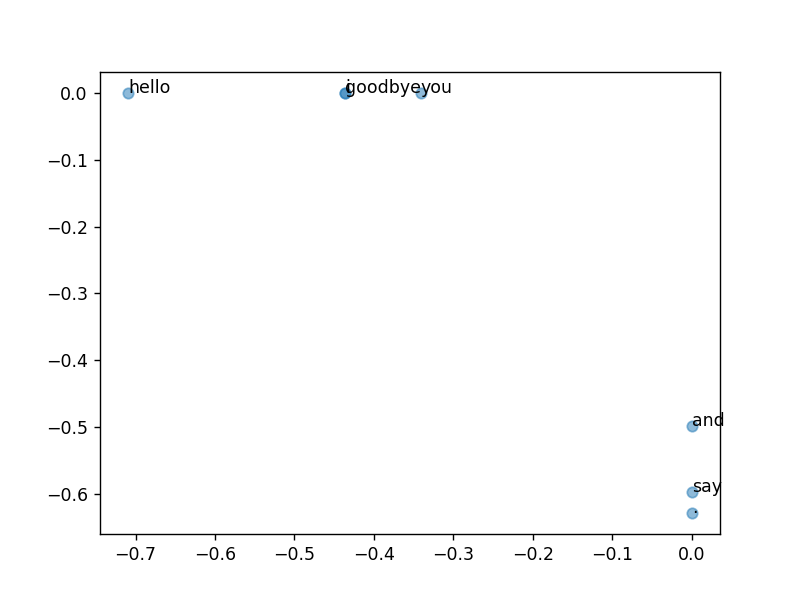

In [44]:
for word,word_id in word_to_id.items():
    plt.annotate(word,(U[word_id,0],U[word_id,1]))
plt.scatter(U[:,0],U[:,1],alpha=0.5)

### PTB 데이터셋

In [45]:
from dataset import ptb

In [46]:
corpus, word_to_id,id_to_word = ptb.load_data('train')

Done


### PTB 데이터셋 평가

In [48]:
!pip install scikit-learn

You should consider upgrading via the 'c:\users\super\anaconda3\envs\tensorflow\python.exe -m pip install --upgrade pip' command.


In [52]:
import sys
sys.path.append('deep2')
from deep2.common.util import most_similar, create_co_matrix, ppmi

window_size = 2
wordvec_size = 100
vocab_size = len(word_to_id)
print('동시발생 수 계산')
C = create_co_matrix(corpus,vocab_size,window_size)
print('PPMI 계산 ...')
W = ppmi(C,verbose=True)
print('svd 계산 ...')
try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W,n_components=wordvec_size,n_iter= -1,random_state=None)
except ImportError:
    U, S, V = np.linalg(W)
word_vecs = U[:,:wordvec_size]
querys = ['you','year','car','toyota']
for query in querys:
    most_similar(query,word_to_id,id_to_word,word_vecs,top=5)

동시발생 수 계산
PPMI 계산 ...


C:\Users\super\R , Python\공부\밑러닝 2\deep2\common\util.py:141: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
C:\Users\super\R , Python\공부\밑러닝 2\deep2\common\util.py:141: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
svd 계산 ...

[query] you
 i: 0.3752132058143616
 enfield: 0.31486940383911133
 maybe: 0.31282204389572144
 mo